In [22]:
import cv2
import numpy as np
import hashlib
from cryptography.fernet import Fernet
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt


In [24]:
# Generate and save the encryption key
key = Fernet.generate_key()

with open("secret.key", "wb") as f:
    f.write(key)

print("Key saved to secret.key")


Key saved to secret.key


In [25]:
# Load the existing encryption key
with open("secret.key", "rb") as f:
    key = f.read()

cipher = Fernet(key)


In [26]:
# Encrypt and Embed Message in Image

def encrypt_and_embed(image_path, message, output_path):
    hash_obj = hashlib.sha256(message.encode())
    message_hash = hash_obj.hexdigest()
    full_message = f"{message}::{message_hash}"

    encrypted = cipher.encrypt(full_message.encode())
    binary_message = ''.join(format(byte, '08b') for byte in encrypted) + '1111111111111110'  # EOF

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    h, w, _ = image.shape
    if len(binary_message) > h * w * 3:
        raise ValueError("Message too long to embed in this image.")

    data_index = 0
    for y in range(h):
        for x in range(w):
            for c in range(3):
                if data_index < len(binary_message):
                    image[y, x, c] = (image[y, x, c] & ~1) | int(binary_message[data_index])
                    data_index += 1

    cv2.imwrite(output_path, image)
    print("Message encrypted and embedded successfully.")

In [28]:
# Extract and Decrypt Message from Image
def extract_and_decrypt(image_path):
    image = cv2.imread(image_path)
    binary_data = ""

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(3):
                binary_data += str(image[y, x, c] & 1)

    bytes_list = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    byte_data = bytearray()
    for byte in bytes_list:
        if byte == '11111110':
            break
        byte_data.append(int(byte, 2))

    try:
        decrypted = cipher.decrypt(bytes(byte_data)).decode()
        if "::" in decrypted:
            message, embedded_hash = decrypted.rsplit("::", 1)
            recalculated_hash = hashlib.sha256(message.encode()).hexdigest()
            if embedded_hash == recalculated_hash:
                return f"Message verified successfully:\n{message}"
            else:
                return "Hash mismatch! Message may have been tampered."
        else:
            return "Message format incorrect. Hash not found."
    except Exception as e:
        return f"Decryption failed: {str(e)}"


In [29]:
# Run Message Embedding and Extraction
original_image_path = r"C:\Users\Admin\Downloads\Input_image_converted.png"
output_image_path = "secure_encoded_image.png"
secret_message = "This is a top-secret hidden message with encryption!"

encrypt_and_embed(original_image_path, secret_message, output_image_path)
Image.open(output_image_path).show()

result = extract_and_decrypt(output_image_path)
print("Decoded Message:", result)

Message encrypted and embedded successfully.
Decoded Message: Message verified successfully:
This is a top-secret hidden message with encryption!


In [30]:
# Embed Encrypted File into Image
def embed_file(image_path, file_path, output_image_path):
    with open(file_path, "rb") as f:
        file_data = f.read()

    encrypted = cipher.encrypt(file_data)
    binary_data = ''.join(format(byte, '08b') for byte in encrypted) + '1111111111111110'

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    h, w, _ = image.shape
    if len(binary_data) > h * w * 3:
        raise ValueError("File too large for this image!")

    data_index = 0
    for y in range(h):
        for x in range(w):
            for c in range(3):
                if data_index < len(binary_data):
                    image[y, x, c] = (image[y, x, c] & ~1) | int(binary_data[data_index])
                    data_index += 1

    cv2.imwrite(output_image_path, image)
    print(f"File encrypted and embedded into image: {output_image_path}")

In [31]:
#  Extract and Decrypt Embedded File
def extract_file(encoded_image_path, output_file_path):
    image = cv2.imread(encoded_image_path)
    binary_data = ""

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(3):
                binary_data += str(image[y, x, c] & 1)

    bytes_list = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    byte_data = bytearray()
    for byte in bytes_list:
        if byte == '11111110':
            break
        byte_data.append(int(byte, 2))

    try:
        decrypted = cipher.decrypt(bytes(byte_data))
        with open(output_file_path, "wb") as f:
            f.write(decrypted)
        print(f"File extracted and decrypted: {output_file_path}")
    except Exception as e:
        print(f"Decryption failed: {str(e)}")


In [32]:
# Run File Embedding Process
image_path = r"C:\Users\Admin\Downloads\Input_image_converted.png"
file_path = r"C:\Users\Admin\OneDrive\Documents\testfile.pdf"
output_image_path = "image_with_file_hidden.png"

embed_file(image_path, file_path, output_image_path)


File encrypted and embedded into image: image_with_file_hidden.png


In [ ]:
# Run File Extraction Process
stego_image = "image_with_file_hidden.png"
output_file = "recovered_testfile.pdf"

extract_file(stego_image, output_file)


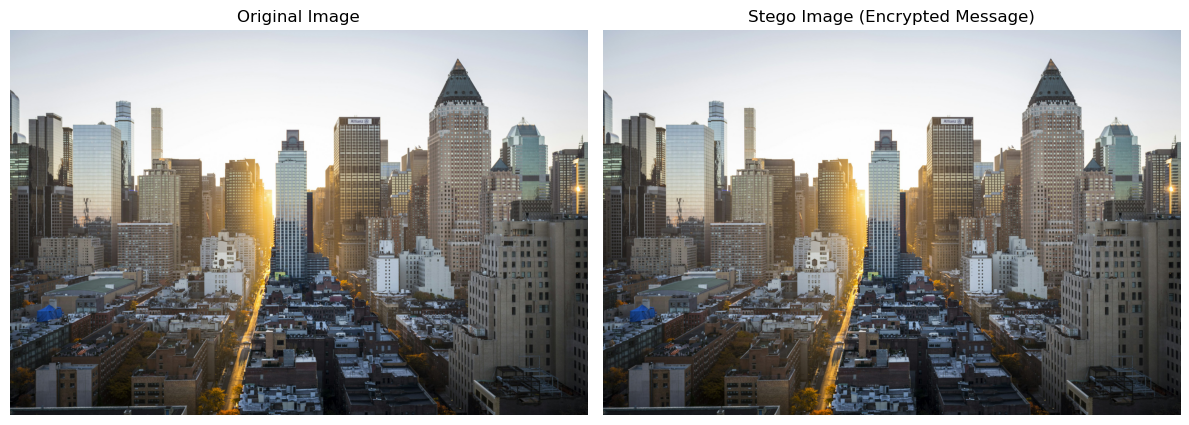

In [42]:
# Visual Comparison of Original and Stego Images
input_img_path = r"C:\Users\Admin\Downloads\Input_image_converted.png"
output_img_path = "secure_encoded_image.png"

original_img = Image.open(input_img_path)
stego_img = Image.open(output_img_path)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(original_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(stego_img)
axs[1].set_title("Stego Image (Encrypted Message)")
axs[1].axis('off')

plt.tight_layout()
plt.show()
